In [21]:
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

## Baseline

In [2]:
# Charger les données
x_train = pd.read_csv("data/x_train.csv")
y_train = pd.read_csv("data/y_train.csv")
x_test = pd.read_csv("data/x_test.csv")

# Merge des features et target
train = x_train.merge(y_train, on="ID")

In [3]:
# Feature engineering : sélection des features
features = ['STOCK'] + \
           [f'RET_{i}' for i in range(1, 6)] + \
           [f'VOLUME_{i}' for i in range(1, 6)]

# Création de la feature supplémentaire : moyenne conditionnelle de RET_1 par SECTOR et INDUSTRY_GROUP (si RANK indisponible)
ret1_mean = train.groupby(['SECTOR', 'INDUSTRY_GROUP'])['RET_1'].mean().reset_index()
ret1_mean = ret1_mean.rename(columns={'RET_1': 'RET_1_MEAN_BY_SECTOR_GROUP'})

# Merge dans train
train = train.merge(ret1_mean, on=['SECTOR', 'INDUSTRY_GROUP'], how='left')
x_test = x_test.merge(ret1_mean, on=['SECTOR', 'INDUSTRY_GROUP'], how='left')

# Ajout de la nouvelle feature aux features
features.append('RET_1_MEAN_BY_SECTOR_GROUP')

# Remplacement des valeurs manquantes par 0
train[features] = train[features].fillna(0)
x_test[features] = x_test[features].fillna(0)

In [4]:
# Définition X, y
X = train[features]
y = train['RET']
X_train, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Création du modèle Random Forest baseline
clf = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train_split)

# Évaluation sur validation
val_preds = clf.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print(f"Accuracy sur le set de validation : {val_acc * 100:.2f}%")

Accuracy sur le set de validation : 52.47%


In [5]:
# Prédiction finale sur le test set pour soumission
test_preds = clf.predict(x_test[features])

# Génération du fichier de soumission
submission = pd.DataFrame({
    'ID': x_test['ID'],
    'RET': test_preds
})
submission.to_csv("submission_baseline.csv", index=False)

## V1 (Nan values handling)

Gestion des Nan

Imputation par groupe (Sector + Industry)

Pourquoi ? Les volumes et retours peuvent dépendre fortement du secteur d’activité. Donc on peut imputer les valeurs manquantes par la médiane (ou moyenne) des valeurs de stocks dans le même groupe.

In [6]:
(x_train.isna().sum()/len(x_train)*100).round(2)

ID                 0.00
DATE               0.00
STOCK              0.00
INDUSTRY           0.00
INDUSTRY_GROUP     0.00
SECTOR             0.00
SUB_INDUSTRY       0.00
RET_1              0.56
VOLUME_1          15.53
RET_2              0.59
VOLUME_2          15.86
RET_3              0.60
VOLUME_3          16.20
RET_4              0.61
VOLUME_4          16.96
RET_5              0.62
VOLUME_5          17.84
RET_6              0.62
VOLUME_6          17.85
RET_7              0.62
VOLUME_7          17.64
RET_8              0.63
VOLUME_8          17.65
RET_9              0.64
VOLUME_9          17.51
RET_10             0.64
VOLUME_10         17.51
RET_11             0.71
VOLUME_11         17.21
RET_12             0.76
VOLUME_12         14.94
RET_13             0.80
VOLUME_13         14.10
RET_14             1.05
VOLUME_14         14.56
RET_15             1.19
VOLUME_15         15.86
RET_16             1.26
VOLUME_16         16.07
RET_17             1.27
VOLUME_17         14.89
RET_18          

In [7]:
# ------------------------
# Étape 1 : Chargement des données
# ------------------------

x_train = pd.read_csv("data/x_train.csv")
y_train = pd.read_csv("data/y_train.csv")
x_test = pd.read_csv("data/x_test.csv")

# Merge train input + output
train = x_train.merge(y_train, on="ID")

In [8]:
# ------------------------
# Étape 2 : Feature engineering
# ------------------------

# Listes des colonnes de features
ret_cols = [f'RET_{i}' for i in range(1, 21)]
vol_cols = [f'VOLUME_{i}' for i in range(1, 21)]
base_features = ['STOCK', 'SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']
features = base_features + ret_cols + vol_cols

# Feature additionnelle : moyenne de RET_1 par SECTOR et INDUSTRY_GROUP
ret1_mean = train.groupby(['SECTOR', 'INDUSTRY_GROUP'])['RET_1'].mean().reset_index()
ret1_mean = ret1_mean.rename(columns={'RET_1': 'RET_1_MEAN_BY_SECTOR_GROUP'})

# Merge dans train et test
train = train.merge(ret1_mean, on=['SECTOR', 'INDUSTRY_GROUP'], how='left')
x_test = x_test.merge(ret1_mean, on=['SECTOR', 'INDUSTRY_GROUP'], how='left')
features.append('RET_1_MEAN_BY_SECTOR_GROUP')

In [9]:
# ------------------------
# Étape 3 : Imputation des NaNs par médiane sectorielle + indicateurs de missing
# ------------------------

def impute_by_group(df, feature_cols, group_cols, method="median"):
    for col in feature_cols:
        # Ajouter une colonne binaire indiquant les NaNs
        df[f'{col}_MISSING'] = df[col].isna().astype(int)

        # Imputation groupée
        if method == "mean":
            values = df.groupby(group_cols)[col].transform('mean')
        elif method == "median":
            values = df.groupby(group_cols)[col].transform('median')
        df[col] = df[col].fillna(values)

        # S'il reste des NaNs (groupe entièrement vide), imputer par 0
        df[col] = df[col].fillna(0)
    return df

x_train = impute_by_group(x_train, ret_cols + vol_cols, ['SECTOR', 'INDUSTRY_GROUP'])
x_test = impute_by_group(x_test, ret_cols + vol_cols, ['SECTOR', 'INDUSTRY_GROUP'])

train = impute_by_group(train, ret_cols + vol_cols, ['SECTOR', 'INDUSTRY_GROUP'])

# Ajout des indicateurs de missing dans les features
missing_flags = [f'{col}_MISSING' for col in ret_cols + vol_cols]
features += missing_flags

In [10]:
# ------------------------
# Étape 4 : Split train / validation
# ------------------------

X = train[features]
y = train['RET']

X_train, X_val, y_train_split, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------
# Étape 5 : Entraînement du modèle
# ------------------------

clf = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train_split)

# ------------------------
# Étape 6 : Évaluation
# ------------------------

val_preds = clf.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print(f"✅ Accuracy sur validation : {val_acc * 100:.2f}%")

✅ Accuracy sur validation : 53.42%


In [11]:
# ------------------------
# Étape 7 : Prédiction sur x_test
# ------------------------

test_preds = clf.predict(x_test[features])
test_pred_proba = clf.predict_proba(x_test[features])[:, 1]

# ------------------------
# Étape 8 : Création du fichier de soumission
# ------------------------

submission = pd.DataFrame({
    'ID': x_test['ID'],
    'RET': test_preds
})
submission.to_csv("submission_v1.csv", index=False)

### Visualisation Cumulative Return per -20 Historical days

In [12]:
def plot_stock_point(df_x, stock_id, date_id, 
                     df_y=None, y_pred_proba=None):
    """
    Visualise les RET/VOLUME historiques + RET réel (y_train) ou prédiction proba (x_test).

    Args:
        df_x (pd.DataFrame): x_train ou x_test
        stock_id (int): identifiant du stock
        date_id (int): identifiant de la date
        df_y (pd.DataFrame, optional): y_train (avec colonnes ID et RET)
        y_pred_proba (float, optional): probabilité prédite (entre 0 et 1)
    """
    row = df_x[(df_x["STOCK"] == stock_id) & (df_x["DATE"] == date_id)]
    if row.empty:
        print(f"❌ Aucune donnée pour STOCK={stock_id}, DATE={date_id}")
        return

    row = row.iloc[0]
    point_id = row['ID']  # Pour liaison avec df_y

    # Récupération des RET et VOLUME historiques
    ret_cols = [f"RET_{i}" for i in range(20, 0, -1)]
    vol_cols = [f"VOLUME_{i}" for i in range(20, 0, -1)]

    returns = np.nan_to_num(row[ret_cols].values, nan=0.0)
    volumes = np.nan_to_num(row[vol_cols].values, nan=0.0)
    cumulative_return = np.cumprod(1 + returns)
    x = list(range(-20, 0))

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Ligne bleue : cumulative return
    ax1.plot(x, cumulative_return, color='blue', label='Cumulative Return')
    ax1.set_ylabel('Cumulative Return', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Barres vertes : relative volume
    ax2 = ax1.twinx()
    ax2.bar(x, volumes, color='green', alpha=0.3)
    ax2.set_ylabel('Relative Volume', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax1.set_xticks(x)
    ax1.set_xlabel('Day')
    ax1.set_title(f"Stock {stock_id} – Date {date_id}")

    y_pos = cumulative_return[-1]

    # === RET réel si y_train fourni ===
    if df_y is not None:
        true_ret = df_y[df_y["ID"] == point_id]["RET"]
        if not true_ret.empty:
            value = true_ret.values[0]
            arrow = '↑' if value == 1 else '↓'
            ax1.scatter(0, y_pos, color='green' if value == 1 else 'red', s=50, zorder=5)
            ax1.annotate(f"{arrow} (RET={value})", (0, y_pos),
                         color='green' if value == 1 else 'red', fontsize=12, ha='center', va='bottom' if value == 1 else 'top')

    # === RET prédite si probabilité fournie ===
    elif y_pred_proba is not None:
        arrow = '↑' if y_pred_proba >= 0.5 else '↓'
        color = 'red'
        conf = round(y_pred_proba, 2)
        ax1.scatter(0, y_pos, color='green' if y_pred_proba >= 0.5 else 'red', s=50, zorder=5)
        ax1.annotate(f"{arrow} ({conf})", (0, y_pos),
                     color='green' if y_pred_proba >= 0.5 else 'red', 
                     fontsize=12, ha='center', va='bottom' if y_pred_proba >= 0.5 else 'top')

    ax1.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax1.grid(True)
    plt.tight_layout()
    plt.show()

### Exemples du Train Set (avec vrai label = True / False)

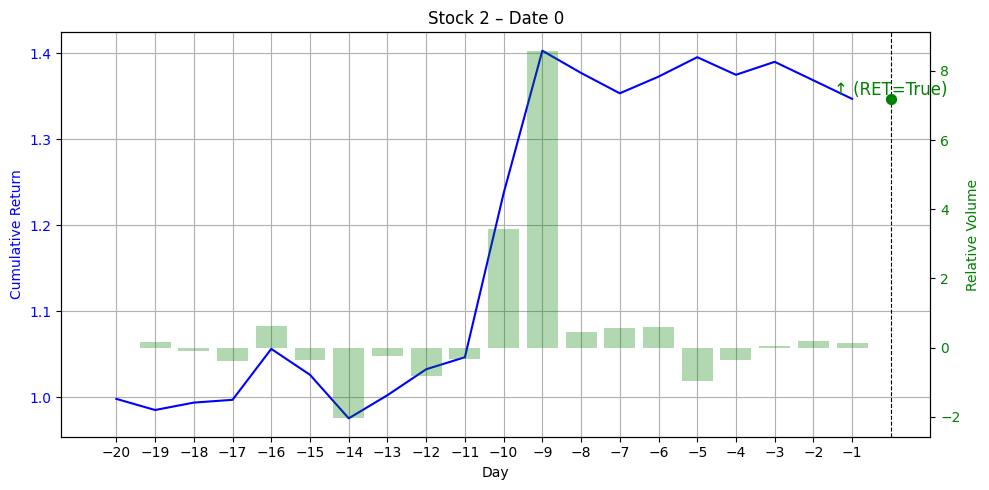

In [13]:
plot_stock_point(x_train, stock_id=2, date_id=0, df_y=y_train)

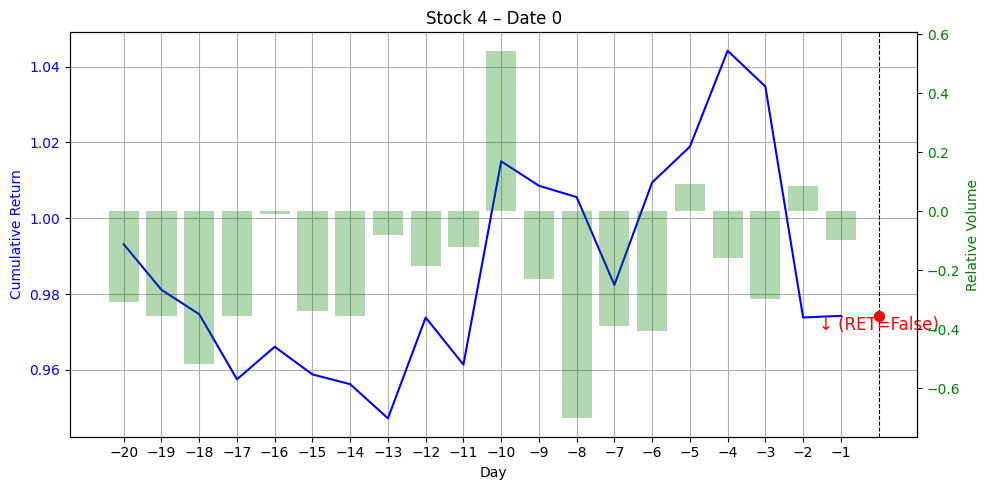

In [14]:
plot_stock_point(x_train, stock_id=4, date_id=0, df_y=y_train)

### Exemple du Test Set (sans vrai label, donc on affiche la predict_proba)

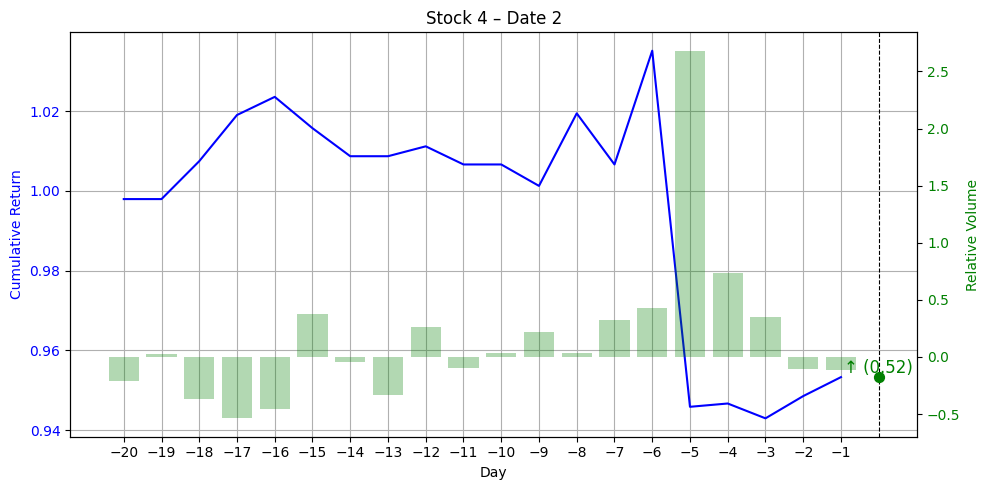

In [15]:
stock_id = 4
date_id = 2

row = x_test[(x_test["STOCK"] == stock_id) & (x_test["DATE"] == date_id)]
index = row.index[0]
proba = test_pred_proba[index]
plot_stock_point(x_test, stock_id=stock_id, date_id=date_id, y_pred_proba=proba)

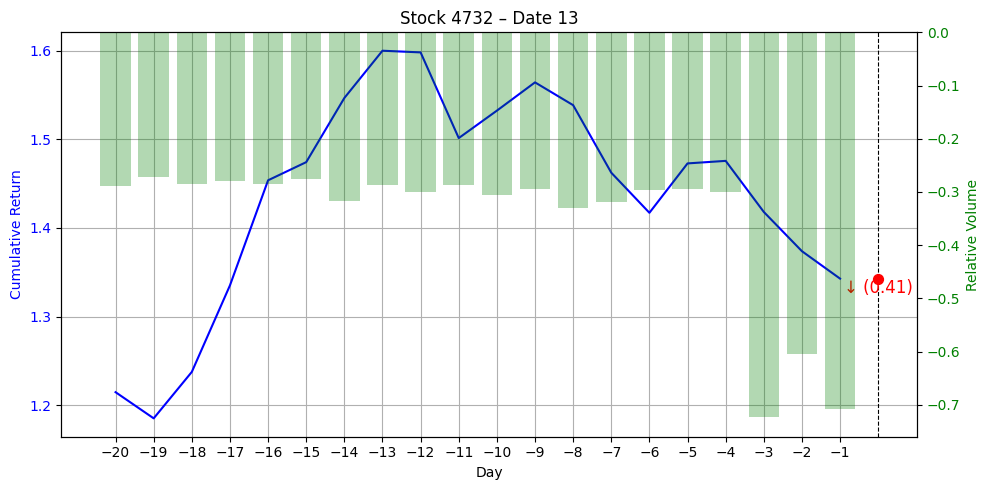

In [16]:
stock_id = 4732
date_id = 13

row = x_test[(x_test["STOCK"] == stock_id) & (x_test["DATE"] == date_id)]
index = row.index[0]
proba = test_pred_proba[index]
plot_stock_point(x_test, stock_id=stock_id, date_id=date_id, y_pred_proba=proba)

## V2 (Feature Engineering)

In [17]:
# Chargement des données
x_train = pd.read_csv("data/x_train.csv")
y_train = pd.read_csv("data/y_train.csv")
train = x_train.merge(y_train, on="ID")

# Définition des colonnes
ret_cols = [f"RET_{i}" for i in range(1, 21)]
vol_cols = [f"VOLUME_{i}" for i in range(1, 21)]
base_features = ['STOCK', 'SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']
features = base_features + ret_cols + vol_cols

# Ajouter la moyenne de RET_1 par SECTOR + INDUSTRY_GROUP
ret1_mean = train.groupby(['SECTOR', 'INDUSTRY_GROUP'])['RET_1'].mean().reset_index()
ret1_mean = ret1_mean.rename(columns={'RET_1': 'RET_1_MEAN_BY_SECTOR_GROUP'})
train = train.merge(ret1_mean, on=['SECTOR', 'INDUSTRY_GROUP'], how='left')
features.append("RET_1_MEAN_BY_SECTOR_GROUP")

# Imputation sectorielle + flags de missing
def impute_by_group(df, feature_cols, group_cols, method="median"):
    df = df.copy()
    for col in feature_cols:
        df[f'{col}_MISSING'] = df[col].isna().astype(int)
        if method == "mean":
            values = df.groupby(group_cols)[col].transform('mean')
        elif method == "median":
            values = df.groupby(group_cols)[col].transform('median')
        df[col] = df[col].fillna(values)
        df[col] = df[col].fillna(0)
    return df

train = impute_by_group(train, ret_cols + vol_cols, ['SECTOR', 'INDUSTRY_GROUP'])
missing_flags = [f'{col}_MISSING' for col in ret_cols + vol_cols]
features += missing_flags

In [18]:
# Feature engineering à tester
def add_feature(df, feature_name):
    df = df.copy()
    if feature_name == "RET_CUM_5":
        df["RET_CUM_5"] = df[[f"RET_{i}" for i in range(1, 6)]].sum(axis=1)
    elif feature_name == "RET_CUM_10":
        df["RET_CUM_10"] = df[[f"RET_{i}" for i in range(1, 11)]].sum(axis=1)
    elif feature_name == "RET_CUM_20":
        df["RET_CUM_20"] = df[[f"RET_{i}" for i in range(1, 21)]].sum(axis=1)
    elif feature_name == "RET_STD_5":
        df["RET_STD_5"] = df[[f"RET_{i}" for i in range(1, 6)]].std(axis=1)
    elif feature_name == "RET_STD_20":
        df["RET_STD_20"] = df[[f"RET_{i}" for i in range(1, 21)]].std(axis=1)
    elif feature_name == "RET_POS_10":
        df["RET_POS_10"] = (df[[f"RET_{i}" for i in range(1, 11)]] > 0).sum(axis=1)
    elif feature_name == "VOLUME_ANOMALY":
        df["VOLUME_MEAN_5"] = df[[f"VOLUME_{i}" for i in range(1, 6)]].mean(axis=1)
        df["VOLUME_ANOMALY"] = df["VOLUME_1"] / (df["VOLUME_MEAN_5"] + 1e-5)
    elif feature_name == "RET_VOL_INTERACT":
        df["RET_VOL_INTERACT"] = df["RET_1"] * df["VOLUME_1"]
    elif feature_name == "RET_TREND_FLIP":
        df["RET_TREND_FLIP"] = ((df["RET_1"] > 0).astype(int) != (df["RET_2"] > 0).astype(int)).astype(int)
    elif feature_name == "RET_CUM_5_SECTOR_DIFF":
        df["RET_CUM_5"] = df[[f"RET_{i}" for i in range(1, 6)]].sum(axis=1)
        sector_avg = df.groupby("SECTOR")["RET_CUM_5"].transform("mean")
        df["RET_CUM_5_SECTOR_DIFF"] = df["RET_CUM_5"] - sector_avg
    return df

# Liste des nouvelles features à tester
feature_list = [
    "RET_CUM_5",
    "RET_CUM_10",
    "RET_CUM_20",
    "RET_STD_5",
    "RET_STD_20",
    "RET_POS_10",
    "VOLUME_ANOMALY",
    "RET_VOL_INTERACT",
    "RET_TREND_FLIP",
    "RET_CUM_5_SECTOR_DIFF"
]

# Évaluation de chaque ajout de feature
results = []

for feature in tqdm(feature_list, desc="Évaluation des nouvelles features"):
    df_aug = add_feature(train, feature)
    new_cols = [col for col in df_aug.columns if col not in train.columns]
    used_features = features + new_cols

    X = df_aug[used_features]
    y = df_aug["RET"]

    X_train, X_val, y_train_split, y_val_split = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42)
    model.fit(X_train, y_train_split)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val_split, y_pred)

    results.append((feature, acc))

# Résultats triés
results.sort(key=lambda x: x[1], reverse=True)

print("\n📊 Résultats du Feature Engineering :")
for feat, acc in results:
    print(f"{feat:<30} --> Accuracy: {acc:.4f}")

Évaluation des nouvelles features: 100%|█████████████████████████████████████████████████████████████████| 10/10 [1:01:43<00:00, 370.35s/it]


📊 Résultats du Feature Engineering :
RET_STD_20                     --> Accuracy: 0.5355
RET_CUM_20                     --> Accuracy: 0.5346
VOLUME_ANOMALY                 --> Accuracy: 0.5345
RET_POS_10                     --> Accuracy: 0.5343
RET_CUM_5                      --> Accuracy: 0.5341
RET_TREND_FLIP                 --> Accuracy: 0.5340
RET_CUM_10                     --> Accuracy: 0.5337
RET_VOL_INTERACT               --> Accuracy: 0.5334
RET_STD_5                      --> Accuracy: 0.5329
RET_CUM_5_SECTOR_DIFF          --> Accuracy: 0.5324


In [18]:
# Use all features

# Chargement des données
x_train = pd.read_csv("data/x_train.csv")
y_train = pd.read_csv("data/y_train.csv")
x_test = pd.read_csv("data/x_test.csv")

train = x_train.merge(y_train, on="ID")

# Définition des colonnes
ret_cols = [f"RET_{i}" for i in range(1, 21)]
vol_cols = [f"VOLUME_{i}" for i in range(1, 21)]
base_features = ['STOCK', 'SECTOR', 'INDUSTRY', 'INDUSTRY_GROUP', 'SUB_INDUSTRY']
features = base_features + ret_cols + vol_cols

# Ajout de RET_1_MEAN_BY_SECTOR_GROUP
ret1_mean = train.groupby(['SECTOR', 'INDUSTRY_GROUP'])['RET_1'].mean().reset_index()
ret1_mean = ret1_mean.rename(columns={'RET_1': 'RET_1_MEAN_BY_SECTOR_GROUP'})
train = train.merge(ret1_mean, on=['SECTOR', 'INDUSTRY_GROUP'], how='left')
x_test = x_test.merge(ret1_mean, on=['SECTOR', 'INDUSTRY_GROUP'], how='left')
features.append('RET_1_MEAN_BY_SECTOR_GROUP')

# Fonction d’imputation + flags
def impute_by_group(df, feature_cols, group_cols, method="median"):
    df = df.copy()
    for col in feature_cols:
        df[f'{col}_MISSING'] = df[col].isna().astype(int)
        if method == "mean":
            values = df.groupby(group_cols)[col].transform('mean')
        elif method == "median":
            values = df.groupby(group_cols)[col].transform('median')
        df[col] = df[col].fillna(values)
        df[col] = df[col].fillna(0)
    return df

# Imputation train / test
train = impute_by_group(train, ret_cols + vol_cols, ['SECTOR', 'INDUSTRY_GROUP'])
x_test = impute_by_group(x_test, ret_cols + vol_cols, ['SECTOR', 'INDUSTRY_GROUP'])

# Ajout des indicateurs de missing
missing_flags = [f'{col}_MISSING' for col in ret_cols + vol_cols]
features += missing_flags

# -------- Feature engineering --------
def add_all_features(df):
    df = df.copy()
    df["RET_CUM_5"] = df[[f"RET_{i}" for i in range(1, 6)]].sum(axis=1)
    df["RET_CUM_10"] = df[[f"RET_{i}" for i in range(1, 11)]].sum(axis=1)
    df["RET_CUM_20"] = df[[f"RET_{i}" for i in range(1, 21)]].sum(axis=1)
    df["RET_STD_5"] = df[[f"RET_{i}" for i in range(1, 6)]].std(axis=1)
    df["RET_STD_20"] = df[[f"RET_{i}" for i in range(1, 21)]].std(axis=1)
    df["RET_POS_10"] = (df[[f"RET_{i}" for i in range(1, 11)]] > 0).sum(axis=1)
    df["VOLUME_MEAN_5"] = df[[f"VOLUME_{i}" for i in range(1, 6)]].mean(axis=1)
    df["VOLUME_ANOMALY"] = df["VOLUME_1"] / (df["VOLUME_MEAN_5"] + 1e-5)
    df["RET_VOL_INTERACT"] = df["RET_1"] * df["VOLUME_1"]
    df["RET_TREND_FLIP"] = ((df["RET_1"] > 0).astype(int) != (df["RET_2"] > 0).astype(int)).astype(int)
    # df["RET_CUM_5_SECTOR_DIFF"] = df["RET_CUM_5"] - df.groupby("SECTOR")["RET_CUM_5"].transform("mean") # 100% correlée à RET_CUM_5
    return df

train = add_all_features(train)
x_test = add_all_features(x_test)

# Ajout des nouvelles colonnes à la liste de features
new_features = [
    "RET_CUM_5", 
    "RET_CUM_10", 
    "RET_CUM_20",
    "RET_STD_5", 
    "RET_STD_20", 
    "RET_POS_10",
    "VOLUME_ANOMALY", 
    "RET_VOL_INTERACT",
    "RET_TREND_FLIP",
]
features += new_features

# -------- Entraînement du modèle --------
X = train[features]
y = train["RET"]

X_train, X_val, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42)
model.fit(X_train, y_train_split)

# Évaluation
y_val_pred = model.predict(X_val)
acc = accuracy_score(y_val_split, y_val_pred)
print(f"✅ Accuracy sur validation set: {acc:.4f}")

# -------- Prédiction sur test --------
X_test = x_test[features]
y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > 0.5).astype(int)

# Sauvegarde du fichier de soumission
submission = pd.DataFrame({"ID": x_test["ID"], "RET": y_test_pred})
submission.to_csv("submission_v2.csv", index=False)

✅ Accuracy sur validation set: 0.5343


### Trouver le meilleur seuil

In [19]:
def find_best_threshold(y_true, y_proba):
    thresholds = np.linspace(0.1, 0.9, 81)  # seuils de 0.1 à 0.9 par pas de 0.01
    best_acc = 0
    best_thresh = 0.5
    for t in thresholds:
        preds = (y_proba > t).astype(int)
        acc = accuracy_score(y_true, preds)
        if acc > best_acc:
            best_acc = acc
            best_thresh = t
    print(f"🔍 Meilleur seuil trouvé: {best_thresh:.3f} avec une accuracy de {best_acc:.4f}")
    return best_thresh

In [20]:
# Probabilités sur validation
y_val_proba = model.predict_proba(X_val)[:, 1]

# Trouver le meilleur seuil
best_threshold = find_best_threshold(y_val_split, y_val_proba)

# Prédiction finale avec le seuil optimisé
y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > best_threshold).astype(int)

🔍 Meilleur seuil trouvé: 0.500 avec une accuracy de 0.5343


### Correlation entre features

In [8]:
features

['STOCK',
 'SECTOR',
 'INDUSTRY',
 'INDUSTRY_GROUP',
 'SUB_INDUSTRY',
 'RET_1',
 'RET_2',
 'RET_3',
 'RET_4',
 'RET_5',
 'RET_6',
 'RET_7',
 'RET_8',
 'RET_9',
 'RET_10',
 'RET_11',
 'RET_12',
 'RET_13',
 'RET_14',
 'RET_15',
 'RET_16',
 'RET_17',
 'RET_18',
 'RET_19',
 'RET_20',
 'VOLUME_1',
 'VOLUME_2',
 'VOLUME_3',
 'VOLUME_4',
 'VOLUME_5',
 'VOLUME_6',
 'VOLUME_7',
 'VOLUME_8',
 'VOLUME_9',
 'VOLUME_10',
 'VOLUME_11',
 'VOLUME_12',
 'VOLUME_13',
 'VOLUME_14',
 'VOLUME_15',
 'VOLUME_16',
 'VOLUME_17',
 'VOLUME_18',
 'VOLUME_19',
 'VOLUME_20',
 'RET_1_MEAN_BY_SECTOR_GROUP',
 'RET_1_MISSING',
 'RET_2_MISSING',
 'RET_3_MISSING',
 'RET_4_MISSING',
 'RET_5_MISSING',
 'RET_6_MISSING',
 'RET_7_MISSING',
 'RET_8_MISSING',
 'RET_9_MISSING',
 'RET_10_MISSING',
 'RET_11_MISSING',
 'RET_12_MISSING',
 'RET_13_MISSING',
 'RET_14_MISSING',
 'RET_15_MISSING',
 'RET_16_MISSING',
 'RET_17_MISSING',
 'RET_18_MISSING',
 'RET_19_MISSING',
 'RET_20_MISSING',
 'VOLUME_1_MISSING',
 'VOLUME_2_MISSING',
 'VO

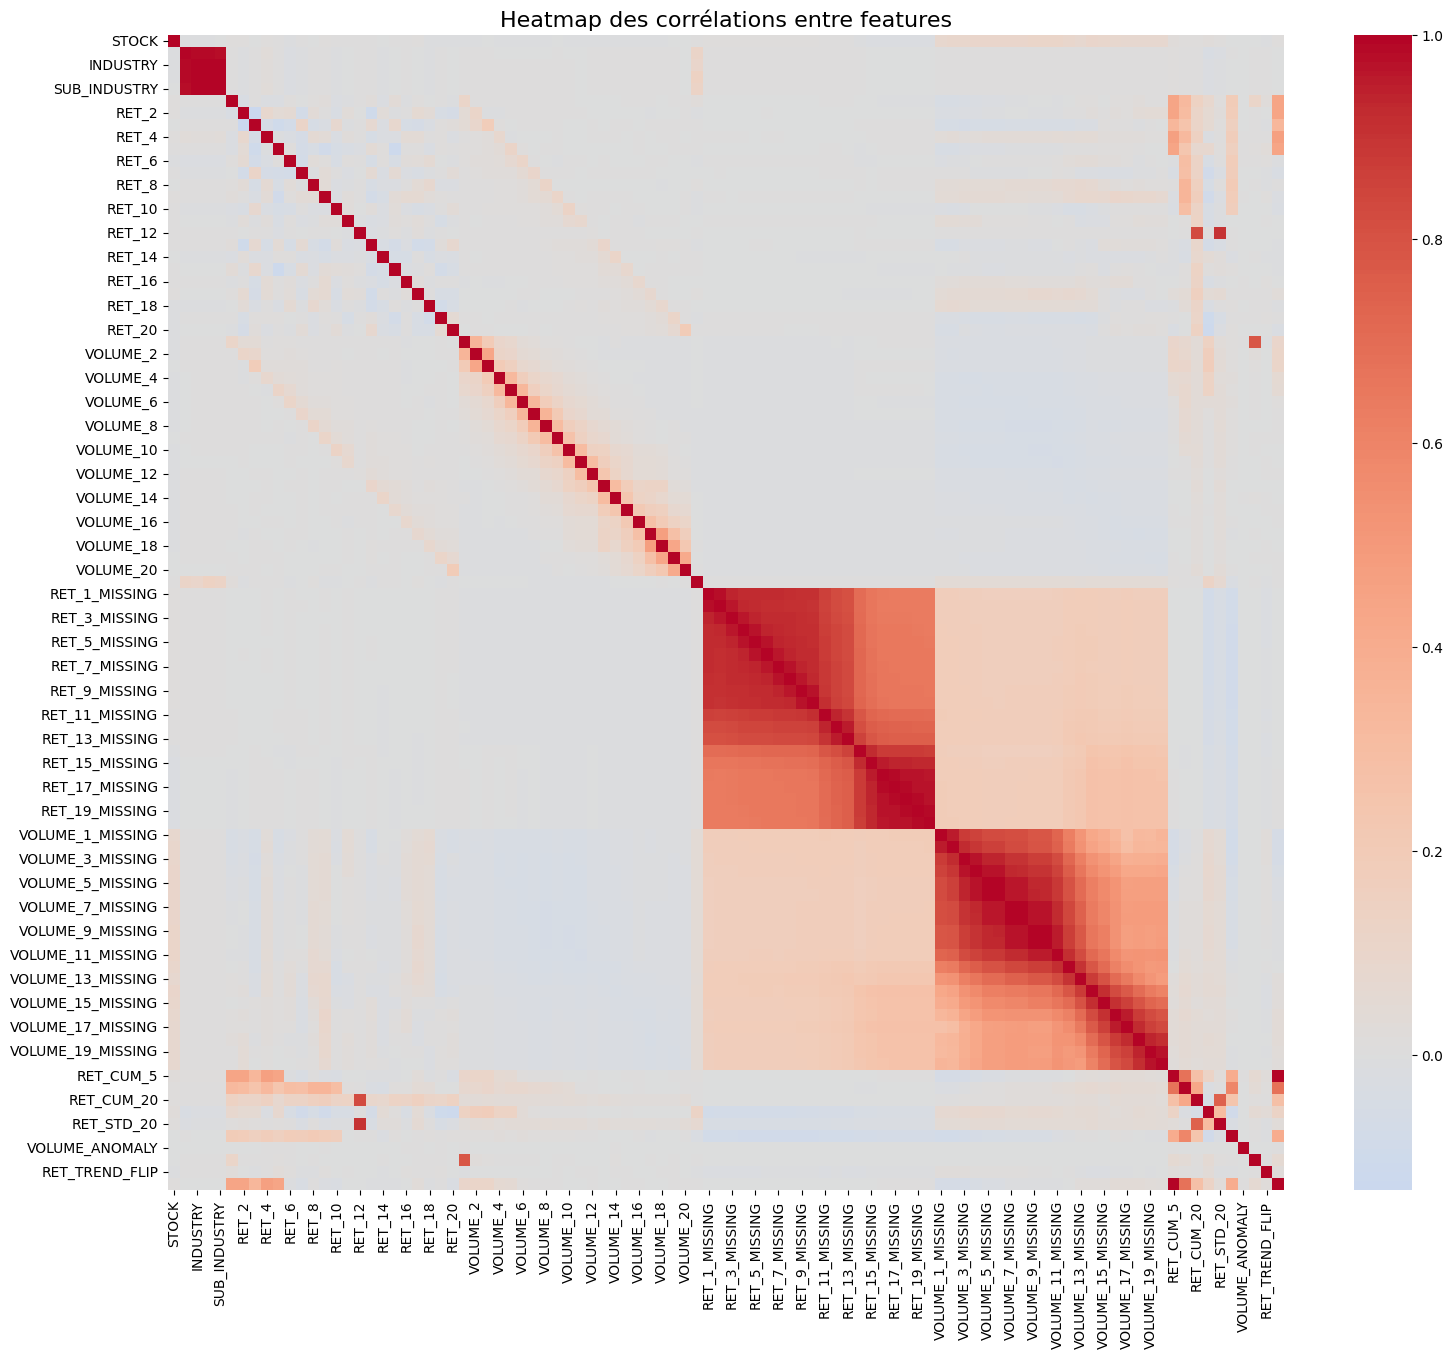

In [10]:
numeric_features = train[features].select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr(method='pearson')

# --------------------------
# Affichage heatmap
# --------------------------
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title("Heatmap des corrélations entre features", fontsize=16)
plt.show()

In [16]:
# --------------------------
# Paires fortement corrélées
# --------------------------
def get_strong_correlations(corr_matrix, threshold=0.70):
    strong_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > threshold and not corr_matrix.columns[i].endswith("_MISSING") and not corr_matrix.columns[j].endswith("_MISSING"):
                strong_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
    return sorted(strong_pairs, key=lambda x: -abs(x[2]))

strong_corrs = get_strong_correlations(corr_matrix)

# Affichage des corrélations fortes
print("🔍 Paires de features fortement corrélées (|corr| > 0.90) :")
for f1, f2, corr in strong_corrs:
    print(f"{f1} <--> {f2} : corr = {corr:.3f}")

🔍 Paires de features fortement corrélées (|corr| > 0.90) :
RET_CUM_5 <--> RET_CUM_5_SECTOR_DIFF : corr = 1.000
INDUSTRY <--> SUB_INDUSTRY : corr = 0.998
INDUSTRY <--> INDUSTRY_GROUP : corr = 0.995
INDUSTRY_GROUP <--> SUB_INDUSTRY : corr = 0.994
SECTOR <--> INDUSTRY_GROUP : corr = 0.983
SECTOR <--> INDUSTRY : corr = 0.982
SECTOR <--> SUB_INDUSTRY : corr = 0.980
RET_12 <--> RET_STD_20 : corr = 0.898
RET_12 <--> RET_CUM_20 : corr = 0.820
VOLUME_1 <--> RET_VOL_INTERACT : corr = 0.782
RET_CUM_20 <--> RET_STD_20 : corr = 0.741


## Optimisation des hyper-paramètres (GridSearchCV)

In [ ]:
# Définir le modèle de base
base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grille des hyperparamètres à tester
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Grid search avec validation croisée
grid_search = GridSearchCV(
    base_rf,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Lancer l’optimisation
grid_search.fit(X_train, y_train_split)

# Affichage des meilleurs hyperparamètres
print("✅ Meilleurs paramètres trouvés :", grid_search.best_params_)

# Évaluation sur le set de validation
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val_split, y_val_pred)
print(f"🎯 Accuracy sur validation set : {accuracy:.4f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
